# Facial Expression Recognition Classification

In this notebook, we utilize Opencv, Keras and Tensorflow-gpu 2.x to create a real-time facial expression recognition classifier. We will use the [fer2013](https://www.kaggle.com/deadskull7/fer2013) dataset from Kaggle.There are two components in our project:

1. Building an emotion classifier (This is what most of the notebook is devoted to)
    * We'll experiment multiple training architectures to get as good a performance as possible for our emotion classifier.
2. Building an facial detector in real-time for emotion classification (We'll take advantage of [tensorflow object detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) and Opencv for our real-time facial detector)
    * The detector will feed facial images in real-time to the emotion classifier for classification

In [14]:
# Importing dependencies
import pandas as pd
from typing import List
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import functools
import os
from pathlib import Path
import imutils

# Model Building
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout ,Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy, sparse_categorical_accuracy
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import *


In [2]:
# I'm using tensorflow-gpu
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Exploring

In [3]:
# Utilities Function
def learning_curve():
    """Plot the learning curve for the trained model 
    """
    history = h.history
    train_loss = history['loss']
    train_acc = history['sparse_categorical_accuracy']
    val_loss = history['val_loss']
    val_acc = history['val_sparse_categorical_accuracy']

    plt.figure()
    plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='val loss')
    plt.legend()

    plt.figure()
    plt.plot(train_acc, label='train acc')
    plt.plot(val_acc, label='val acc')
    plt.legend()
def str_to_float(string: str) -> List[float]:
    """Transform str object into an array of floats
    Input
    -----
    string: str
        The values to be transformed
    Output
    ------
        Array-like of float values corresponding to the input
    """
    string = string.split(' ')
    values = [float(x) for x in string]
    return values
def plot_dist(data: pd.DataFrame, filter='Training', figsize=(12,8), color='black'):
    """Returns a figure that shows the distribution of the specified data
    Input
    -----
        data: pd.DataFrame
            pandas dataframe
        filter: str 
            one of ['Training', 'PublicTest','PrivateTest']
        figsize: tuple
            height and width of the returned figure
        color: matplotlib defined color scheme
            THe color of the title
        """
    plt.figure(figsize=figsize)
    filters = data.loc[data.Usage == filter, ['emotion', 'numerical']]              
    freq = list(filters['emotion'].value_counts().values)
    emo = np.arange(0, len(freq), step=1)
    plt.bar(x=emo, height=freq)
    plt.title(f'{filter} distribution', fontsize=25, color=color)
    plt.xlabel('Emotions', color=color)
    plt.xticks(ticks=emo,labels=label_map)
    plt.ylabel('Frequency', color=color)
def split_data(df: pd.DataFrame, filter: str='Training') -> tf.data.Dataset:
    """Filter out data from the DataFrame using given filter variable
    Input
    -----
    df: pd.DataFrame
        data to be processed
    filter: str 
        One of 'Training', 'PublicTest','PrivateTest'
    Output
    ------
        tf.data.Dataset"""
    data = []
    label = []
    for idx, val in enumerate(df.loc[df.Usage == filter, ['emotion', 'numerical']].values):
        data.append(val[1])
        label.append(val[0])
    data = np.array(data)
    data= data.reshape(-1, 48, 48,1).astype('float32') / 255
    label = np.array(label)

    return tf.data.Dataset.from_tensor_slices((data, label))    
def obs(data):
    """Returns the number of examples in a tf.data.Dataset object"""
    count = 0
    for instance in data:
        count += 1
    print(f'Number of observations is {count}')
    return count

In [4]:
data =pd.read_csv('./data/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
# Check the data type of each variable
data.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

1. The dataset contains 3 variables. 'Emotion' denotes the type of emotions that the image (represented by the variable 'pixels') portrays. The variable 'Usage' specifies whether the example is used in training , validation or test sets.
2. The pixel variable is of object type, however. In pandas, this means each example in pixels is a string object. But we know that an image is represented by a matrix of values from 0 to 255. Therefore, we need to transform this variable into float type. We will utilize the str_to_float function defined in the beginning cell and store the transformed variable in 'numerical'.

In [6]:
# Transforming Variables
data['numerical'] = data['pixels'].apply(str_to_float)
display(data.head())
print('==='*30)
print(type(data.numerical[0][0]))

,emotion,pixels,Usage,numerical
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63...."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20...."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


<class 'float'>


Now each example in the new variable is a list of float values

In [7]:
# Number of examples in each dataset
display(data.Usage.value_counts())

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

We have 28k images in training set, and 3.5k images in each of the test and validation sets.

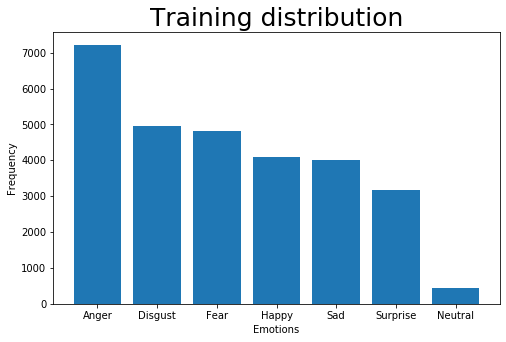

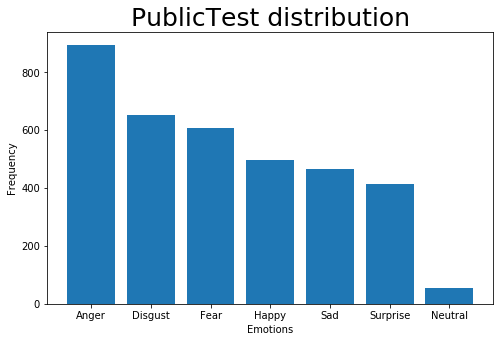

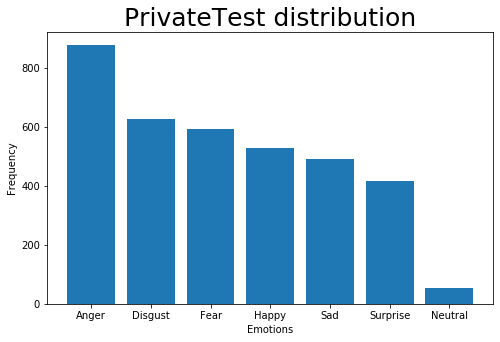

In [8]:
# Plotting distribution of emotions in each dataset
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
figsize = (8,5)
# Training Dist
plot_dist(data=data, filter='Training', figsize=figsize)
# Val Dist
plot_dist(data=data, filter='PublicTest',figsize=figsize)
# Test Dist
plot_dist(data=data, filter='PrivateTest',figsize=figsize)

The distribution of each dataset is similar to each other. Neutral seems to be underrepresented. We might want to downsample other emotions or giving more weight to neutral during training. In this notebook, however, we will train without addressing the imbalance (I'm a little lazy here).

In order to train the model, we need to transform the data into a tf.data.Dataset object. Tensorflow have great documentation [here](https://www.tensorflow.org/guide/keras/train_and_evaluate). I recommend you check it out if you want to assign weight to address imbalances in our datasets. We'll take use of the split_data function defined in the beginning.

In [9]:
# Transform datasets into tf.data.Dataset
train_dataset = split_data(data, filter='Training')
val_dataset = split_data(data, filter='PublicTest')
test_dataset = split_data(data, filter='PrivateTest')

print('Training shape:\t', train_dataset)
print('Val shape:\t', val_dataset)
print('Test shape:\t',test_dataset)

Training shape:	 <TensorSliceDataset shapes: ((48, 48, 1), ()), types: (tf.float32, tf.int32)>
Val shape:	 <TensorSliceDataset shapes: ((48, 48, 1), ()), types: (tf.float32, tf.int32)>
Test shape:	 <TensorSliceDataset shapes: ((48, 48, 1), ()), types: (tf.float32, tf.int32)>


Each tf.data.Dataset object includes the image pixels and its corresponding label. Each image in our dataset is in a grayscale 48x48 shape. 

In [11]:
# Checking the number of examples in each dataset
train_count = obs(data=train_dataset)
val_count = obs(data=val_dataset)
test_count = obs(data=test_dataset)

Number of observations is 28709
Number of observations is 3589
Number of observations is 3589


Let's checkout what each emotion looks like

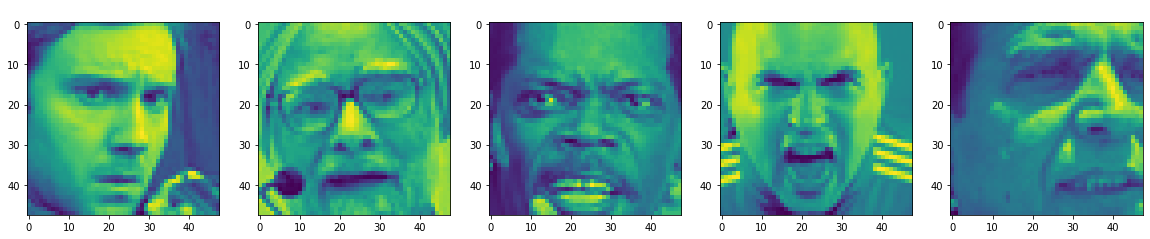

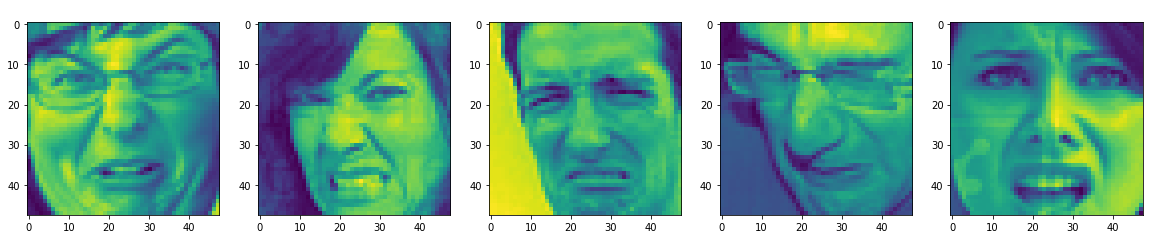

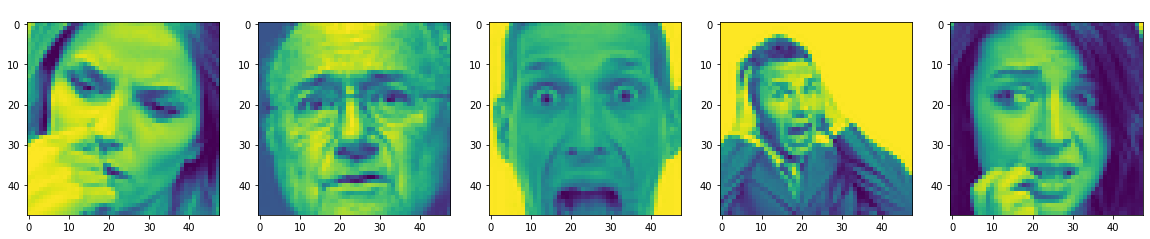

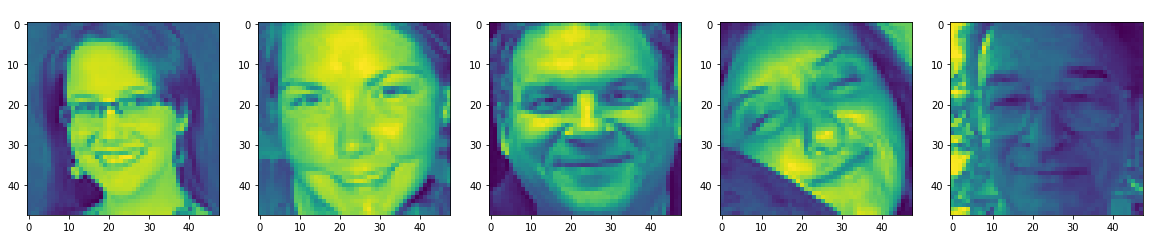

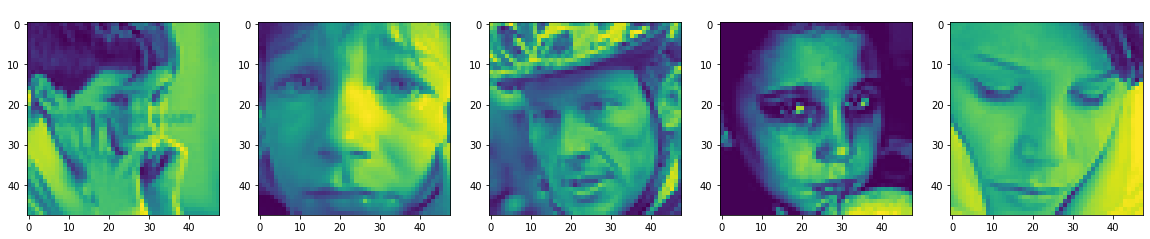

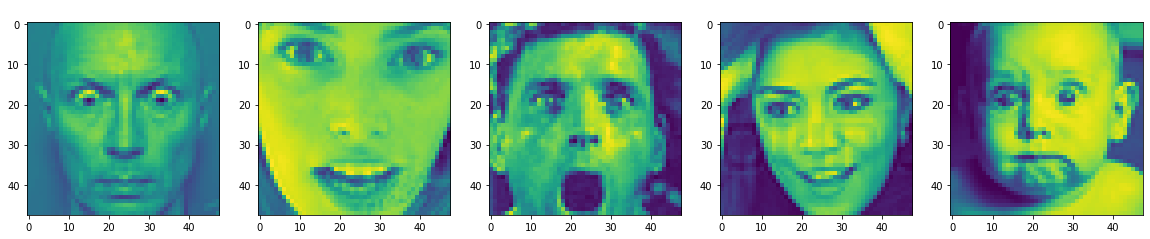

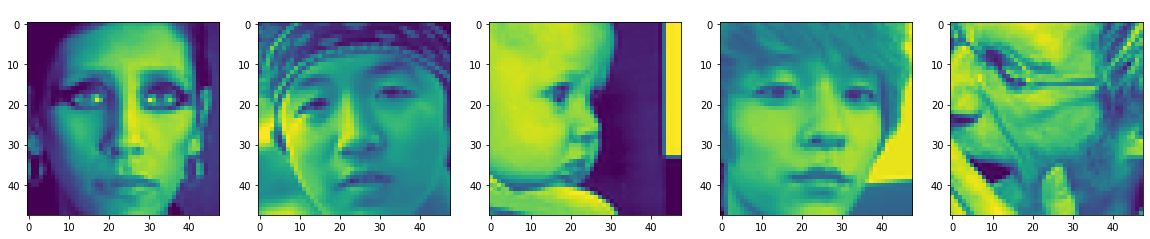

In [11]:
# Check images
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
for idx, label in enumerate(label_map):
    emo = data.loc[data.emotion == idx, 'numerical']
    fig = plt.figure(figsize=(20,15))
    for idx, img in enumerate(emo[0:5]):
        img = np.array(img).reshape(48,48)
        ax = fig.add_subplot(1,5,idx+1)
        ax.imshow(img)
        ax.set_title(f'{label}', color='white')

Some of the images here I deem wrongly labeled. For example, the first image in fear. It doesn't look like fear to me. This means that our classifier will have a hard time converging to an optimal solution.

## Training

In [17]:
# Hyperparameter definition
input_shape = [48,48,1]
BATCH_SIZE = 64
num_epoch = 100
SHUFFLE_BUFFER_SIZE = train_count

In [18]:
# Again please refer to tensorflow documentation to create dataset for model training
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Batch Normalization without Dropout

We'll be using a model with 6 conv2d layers and 1 dense layer on top for classification. According to [this article]('./papers/BN.pdf'), the use of batch normalization after the convolutional layer addresses the change in distribution between conv layers and acts as a regularizer, thereby eliminating the need to use dropout. So we'll train a model with BN layer and no dropout and test it with one with dropout for this dataset to see which one performs better.

In [14]:
def my_model_nodropout():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'],optimizer='adam')
    
    return model

In [15]:
model=my_model_nodropout()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [16]:
path_model='./models/model_bn_nodropout.h5' # save model at this location after each epoch

model=my_model_nodropout() # create the model

# fit the model
# We save the model after each epoch and use early stopping based on val_loss
h=model.fit(train_dataset, 
            verbose=1, 
            validation_data=val_dataset,
            epochs=20,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
                tf.keras.callbacks.EarlyStopping(
                      monitor='val_loss', patience=5, verbose=1)
            ]
            )

Train for 449 steps, validate for 57 steps
Epoch 1/20
449/449 [==============================] - 60s 133ms/step - loss: 1.6351 - sparse_categorical_accuracy: 0.3610 - val_loss: 1.7377 - val_sparse_categorical_accuracy: 0.3522
Epoch 2/20
449/449 [==============================] - 31s 69ms/step - loss: 1.3410 - sparse_categorical_accuracy: 0.4854 - val_loss: 1.3637 - val_sparse_categorical_accuracy: 0.4912
Epoch 3/20
449/449 [==============================] - 30s 67ms/step - loss: 1.1407 - sparse_categorical_accuracy: 0.5692 - val_loss: 1.5001 - val_sparse_categorical_accuracy: 0.4280
Epoch 4/20
449/449 [==============================] - 30s 67ms/step - loss: 1.0020 - sparse_categorical_accuracy: 0.6251 - val_loss: 1.3305 - val_sparse_categorical_accuracy: 0.5043
Epoch 5/20
449/449 [==============================] - 31s 68ms/step - loss: 0.8714 - sparse_categorical_accuracy: 0.6793 - val_loss: 1.3553 - val_sparse_categorical_accuracy: 0.5079
Epoch 6/20
449/449 [==========================

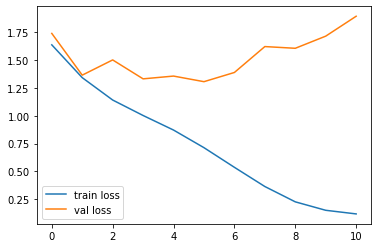

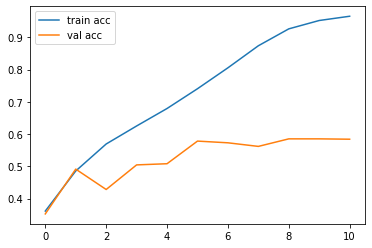

In [17]:
# Utility function defined at the beginning
learning_curve()

The model quickly overfits after 1 epoch. Although the training accuracy is high, the val accuracy is not.

### Batch Normalization with Dropout

This time well apply dropout together with BN layer to train the emotion classifier

In [18]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1)
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'],optimizer='adam')
    
    return model

In [19]:
model=my_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_9 (Batch (None, 24, 24, 128)      

In [20]:
path_model='./models/model_bn_dp02.h5' # save model at this location after each epoch

model=my_model() # create the model

# fit the model
h=model.fit(train_dataset, 
            verbose=1, 
            validation_data=val_dataset,
            epochs=20,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
                tf.keras.callbacks.EarlyStopping(
                      monitor='val_loss', patience=5, verbose=1)
            ]
            )

Train for 449 steps, validate for 57 steps
Epoch 1/20
449/449 [==============================] - 32s 72ms/step - loss: 1.6792 - sparse_categorical_accuracy: 0.3451 - val_loss: 2.4169 - val_sparse_categorical_accuracy: 0.2274
Epoch 2/20
449/449 [==============================] - 31s 68ms/step - loss: 1.3186 - sparse_categorical_accuracy: 0.4995 - val_loss: 1.2937 - val_sparse_categorical_accuracy: 0.5010
Epoch 3/20
449/449 [==============================] - 31s 69ms/step - loss: 1.1389 - sparse_categorical_accuracy: 0.5709 - val_loss: 1.2031 - val_sparse_categorical_accuracy: 0.5433
Epoch 4/20
449/449 [==============================] - 31s 70ms/step - loss: 1.0243 - sparse_categorical_accuracy: 0.6172 - val_loss: 1.1744 - val_sparse_categorical_accuracy: 0.5614
Epoch 5/20
449/449 [==============================] - 31s 68ms/step - loss: 0.9069 - sparse_categorical_accuracy: 0.6580 - val_loss: 1.3295 - val_sparse_categorical_accuracy: 0.5180
Epoch 6/20
449/449 [===========================

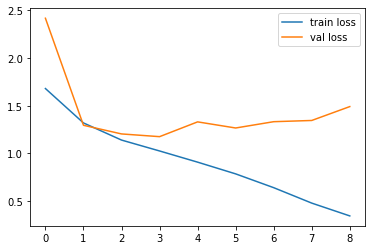

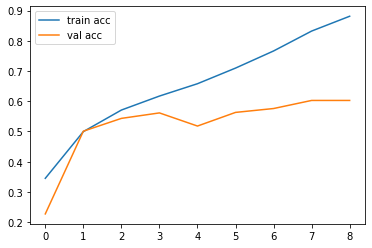

In [21]:
learning_curve()

This time the model performs slightly better. However, it still overfits very quickly. We need to address the overfitting issue. We'll decrease the dropout threshold to 0.5 to see if helps.

### No Batch Normalization with Dropout rate 0.5

In [22]:
model = Sequential()

model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=["sparse_categorical_accuracy"])
model.summary

path_model='./models/model_bn_dp05.h5' # save model at this location after each epoch

# model=my_model() # create the model

# fit the model
h=model.fit(train_dataset, 
            verbose=1, 
            validation_data=val_dataset,
            epochs=100,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
            ]
            )

Train for 449 steps, validate for 57 steps
Epoch 1/100
449/449 [==============================] - 7s 17ms/step - loss: 1.8772 - sparse_categorical_accuracy: 0.2833 - val_loss: 1.6178 - val_sparse_categorical_accuracy: 0.3767
Epoch 2/100
449/449 [==============================] - 7s 15ms/step - loss: 1.6254 - sparse_categorical_accuracy: 0.3583 - val_loss: 1.5441 - val_sparse_categorical_accuracy: 0.3990A: 3s - loss: 1.6475 - sparse_categorical_accuracy: 0.34 - ETA: 
Epoch 3/100
449/449 [==============================] - 7s 15ms/step - loss: 1.5499 - sparse_categorical_accuracy: 0.3997 - val_loss: 1.4767 - val_sparse_categorical_accuracy: 0.4288
Epoch 4/100
449/449 [==============================] - 6s 14ms/step - loss: 1.4938 - sparse_categorical_accuracy: 0.4223 - val_loss: 1.4570 - val_sparse_categorical_accuracy: 0.4441
Epoch 5/100
449/449 [==============================] - 7s 15ms/step - loss: 1.4513 - sparse_categorical_accuracy: 0.4390 - val_loss: 1.4245 - val_sparse_categorical_

As expected, loosening the threshold for dropout worsens the performance of the model. In addition, without BN layers, the model's performance is not as good for both the train and test set.

## Image augmentation

The use of BN layers and Dropout help address the overfitting problem in our classifier as demonstrated with the previous three models. There's one more way we can use to address overfitting. That is image augmentation. Let's take a look at what image augmentation does.

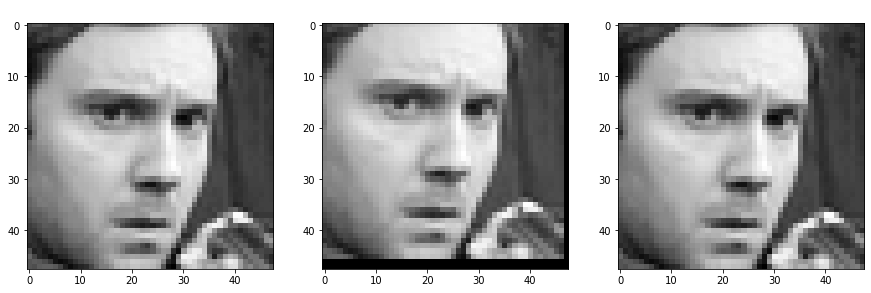

In [41]:
def show_img(img, crop, bright, title):
    fig = plt.figure(figsize=(15,10))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')
    plt.title(title[0], color='white')
    
    plt.subplot(1,3,2)
    plt.imshow(crop, cmap='gray')
    plt.title(title[1], color='white')
    
    plt.subplot(1,3,3)
    plt.imshow(bright, cmap='gray')
    plt.title(title[2], color='white')

title = ['Original Image', 'Randomly resized and cropped Image', 'Randomly brightened image']

img = np.array(data['numerical'][0]).reshape(48,48)

crop = tf.image.resize_with_crop_or_pad(img.reshape(48,48,1), 52, 52) # Add 5 pixels of padding
crop = tf.image.random_crop(crop, size=[48, 48, 1]) # Random crop back to 48x48
crop = crop.numpy().reshape(48,48)

img1 = np.array(data['numerical'][0]).reshape(48,48,1)
bright = tf.image.random_brightness(img1, max_delta=0.5)
bright = bright.numpy().reshape(48,48)

show_img(img, crop, bright, title=title)



In the plot above, the second image was first resized to a size of (52,52) and randomly cropped. The third one was adjusted in brightness. So image augmentation is simply a technique that tweaks the original image in one way or another. For our application, we'll apply these two modifications of images to address overfitting. The idea behind image augmentation is that we artificially created more data to reduce overfitting.

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_epoch = 35
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    return image, label

def augment(image,label):
    image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    image = tf.image.resize_with_crop_or_pad(image, 52, 52) # Add 5 pixels of padding
    image = tf.image.random_crop(image, size=[48, 48, 1]) # Random crop back to 48x48
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    return image,label

train_dataset = split_data(data, filter='Training')
val_dataset = split_data(data, filter='PublicTest')

In [25]:
augmented_train_batches = (train_dataset
                           # Only train on a subset, so you can quickly see the effect.
                           .shuffle(train_count)
                           # The augmentation is added here.
                           .map(augment, num_parallel_calls=AUTOTUNE)
                           .batch(BATCH_SIZE)
                           .prefetch(AUTOTUNE))


validation_batches = (
    val_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE))

### Batch Norm + Augmentation

In [42]:
model = my_model_nodropout()
model_dir = Path(r'.\models\bn_nodp_image_augmentation')
model_dir.mkdir(parents=True, exist_ok=True)

In [35]:
os.path.join(str(model_dir / 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5')

'models\\bn_nodp_image_augmentation\\weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'

Apparently, there are errors with BN layer in tensorflow 2.0 when used in conjunction with EarlyStopping. Therefore, we'll not use EarlyStopping for training.

In [44]:
num_epoch = 35
model = my_model_nodropout()
history = model.fit(augmented_train_batches,
                    epochs=num_epoch,
                    validation_data=validation_batches,
                    verbose=1)

Train for 449 steps, validate for 57 steps
Epoch 1/35
449/449 [==============================] - 34s 76ms/step - loss: 1.6223 - sparse_categorical_accuracy: 0.3655 - val_loss: 1.6057 - val_sparse_categorical_accuracy: 0.3541
Epoch 2/35
449/449 [==============================] - 33s 73ms/step - loss: 1.3016 - sparse_categorical_accuracy: 0.5007 - val_loss: 1.4722 - val_sparse_categorical_accuracy: 0.4525
Epoch 3/35
449/449 [==============================] - 30s 67ms/step - loss: 1.1434 - sparse_categorical_accuracy: 0.5641 - val_loss: 1.2075 - val_sparse_categorical_accuracy: 0.5520
Epoch 4/35
449/449 [==============================] - 30s 67ms/step - loss: 1.0412 - sparse_categorical_accuracy: 0.6065 - val_loss: 1.1338 - val_sparse_categorical_accuracy: 0.5843
Epoch 5/35
449/449 [==============================] - 32s 70ms/step - loss: 0.9590 - sparse_categorical_accuracy: 0.6401 - val_loss: 1.1232 - val_sparse_categorical_accuracy: 0.5938
Epoch 6/35
449/449 [===========================

In [45]:
model.save(str(model_dir / 'bn_nodropout_augmentation.h5'))

Our emotion classifier improves a little bit in comparison with the one without image augmentation. However, it still suffers from heavy overfitting.

### Batch Norm + Dropout + Augmentation 

In [51]:
model_dir = Path(r'.\models\bn_dp_image_augmentation')
model_dir.mkdir(parents=True, exist_ok=True)

In [52]:
model = my_model()
history = model.fit(augmented_train_batches,
                    epochs=num_epoch,
                    validation_data=validation_batches,
                    verbose=1)

Train for 449 steps, validate for 57 steps
Epoch 1/35
449/449 [==============================] - 40s 89ms/step - loss: 1.7454 - sparse_categorical_accuracy: 0.3143 - val_loss: 1.6695 - val_sparse_categorical_accuracy: 0.3263
Epoch 2/35
449/449 [==============================] - 32s 72ms/step - loss: 1.4007 - sparse_categorical_accuracy: 0.4625 - val_loss: 1.4168 - val_sparse_categorical_accuracy: 0.4556
Epoch 3/35
449/449 [==============================] - 30s 67ms/step - loss: 1.2049 - sparse_categorical_accuracy: 0.5424 - val_loss: 1.2174 - val_sparse_categorical_accuracy: 0.5358
Epoch 4/35
449/449 [==============================] - 31s 68ms/step - loss: 1.0982 - sparse_categorical_accuracy: 0.5852 - val_loss: 1.1300 - val_sparse_categorical_accuracy: 0.5740
Epoch 5/35
449/449 [==============================] - 31s 70ms/step - loss: 1.0172 - sparse_categorical_accuracy: 0.6169 - val_loss: 1.0957 - val_sparse_categorical_accuracy: 0.5938
Epoch 6/35
449/449 [===========================

In [53]:
model.save(str(model_dir / 'bn_dp_augmentation.h5'))

The classifier with dropout also suffers from overfitting. It did perform better than the other models, however.

## Transfer Learning

The idea behind transfer learning is that a model trained on a dataset could be reused for another dataset because what the neural network does is learn the representational structure underlying the dataset. Early layers will learn to detect simple, yet ubiquitous features while deeper ones learn to detect data specific features. As a result, we could reuse a model trained on a huge dataset that encompasses a large number of real life objects by reusing the early layers of the pre-trained model while training deeper layers and our own classifier on top of the network. In this notebook, we will reuse Mobilenetv2, trained on imagenet dataset, as we need to lightweight model for real time classification.

In [12]:
# Preprocessing data
IMG_SIZE = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
SHUFFLE_BUFFER_SIZE = train_count
BATCH_SIZE = 64

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.grayscale_to_rgb(image)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label


train_batches = train_dataset.map(format_example).shuffle(
    SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_batches = val_dataset.map(format_example).batch(BATCH_SIZE)

for image, label in train_batches.take(1):
    print(image.shape)

(64, 160, 160, 3)


Mobilenetv2 only accepts images of certain dimensions. So we need to resize the images. In our case, the images is resized from (48,48,1) to (160,160,3)

In [12]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
feature_batch = base_model(image)
print(feature_batch.shape)

(64, 5, 5, 1280)


### Freeze the convolutional base

As mentioned earlier, we only train the deeper layers and our own classifier. But before we train the deeper layers, let's just train the classifier first to see how the model performs by freezing all the weights, thereby preventing the training process from updating the weights.

In [14]:
base_model.trainable = False

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [16]:
# Adding a global average layer on top of the conv layers to reduce computations
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [17]:
# Finally adding our own classifier to train Mobilenet on our specific emotion classification task
prediction_layer = tf.keras.layers.Dense(7)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 7)


In [18]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [19]:
# We'll use RMSprop here. However, you can use Adam or other optimizers as they usually converge to similar results.
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_________________________________________________________________


As shown in the model architecture, this model is weight as the number of parameters in this model is only . This is less computation than our previous models, whose paramters were about 2.7m.

In [21]:
# Checking that all the weights except for the classifier are frozen
len(model.trainable_variables)

2

### Training

In [22]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(val_batches, steps = validation_steps)

20/20 [==============================] - 4s 190ms/step - loss: 2.0524 - accuracy: 0.1859


In [25]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=val_batches)

Train for 449 steps, validate for 57 steps
Epoch 1/10
449/449 [==============================] - 65s 145ms/step - loss: 1.4302 - accuracy: 0.4577 - val_loss: 2.1869 - val_accuracy: 0.2536
Epoch 2/10
449/449 [==============================] - 60s 134ms/step - loss: 1.4206 - accuracy: 0.4569 - val_loss: 2.1800 - val_accuracy: 0.2524
Epoch 3/10
449/449 [==============================] - 63s 140ms/step - loss: 1.4136 - accuracy: 0.4613 - val_loss: 2.1802 - val_accuracy: 0.2519
Epoch 4/10
449/449 [==============================] - 61s 136ms/step - loss: 1.4085 - accuracy: 0.4650 - val_loss: 2.1787 - val_accuracy: 0.2527
Epoch 5/10
449/449 [==============================] - 62s 138ms/step - loss: 1.4042 - accuracy: 0.4649 - val_loss: 2.2300 - val_accuracy: 0.2485
Epoch 6/10
449/449 [==============================] - 60s 133ms/step - loss: 1.3972 - accuracy: 0.4697 - val_loss: 2.1028 - val_accuracy: 0.2611
Epoch 7/10
449/449 [==============================] - 61s 136ms/step - loss: 1.3908 - a

In [ ]:
model.save('./models/mobilenet_freeze.h5')

### Learning Curve

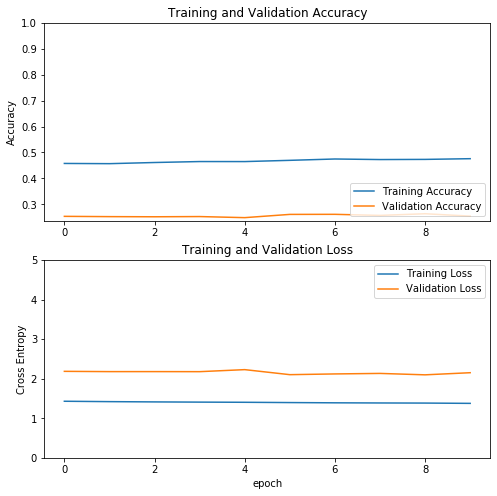

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

The pre-trained model does not seem to perform very well on our dataset as the validation accuracy is less than 0.5

### Un-freeze the top layers of the model

We could unfreeze the deeper layers so that these layers also learns the features specific to our dataset, thereby improving the performance of the model.

In [28]:
base_model.trainable = True

In [29]:
print("Number of layers in the base model: ", len(base_model.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [30]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 1,871,559
Non-trainable params: 395,392
_________________________________________________________________


In [32]:
len(model.trainable_variables)

58

In [33]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=val_batches)

Train for 449 steps, validate for 57 steps
Epoch 10/35
449/449 [==============================] - 127s 282ms/step - loss: 1.3270 - accuracy: 0.4991 - val_loss: 1.7792 - val_accuracy: 0.3176
Epoch 11/35
449/449 [==============================] - 82s 183ms/step - loss: 1.2115 - accuracy: 0.5478 - val_loss: 1.6004 - val_accuracy: 0.3870
Epoch 12/35
449/449 [==============================] - 82s 183ms/step - loss: 1.1228 - accuracy: 0.5862 - val_loss: 1.5399 - val_accuracy: 0.4168
Epoch 13/35
449/449 [==============================] - 77s 171ms/step - loss: 1.0526 - accuracy: 0.6143 - val_loss: 1.5196 - val_accuracy: 0.4216
Epoch 14/35
449/449 [==============================] - 81s 179ms/step - loss: 0.9874 - accuracy: 0.6405 - val_loss: 1.5037 - val_accuracy: 0.4126
Epoch 15/35
449/449 [==============================] - 87s 194ms/step - loss: 0.9343 - accuracy: 0.6650 - val_loss: 1.4952 - val_accuracy: 0.4168
Epoch 16/35
449/449 [==============================] - 84s 186ms/step - loss: 0.

### Fine-tune Learning Curve

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

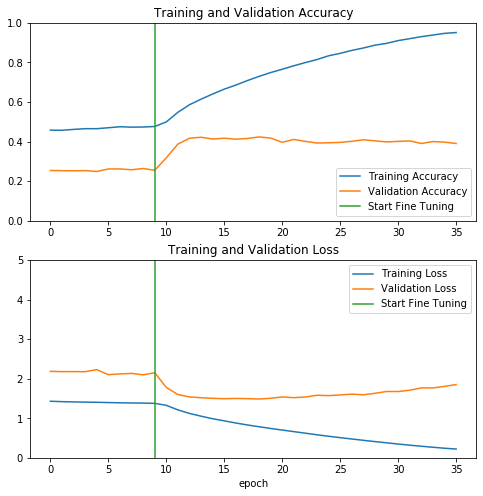

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

This model indeed performs better than the frozen one. However, the performance of the pre-trained model is still no where near the ones we created. 

In [36]:
model.save('./models/mobilenet_finetuned.h5')

## Evaluating with test data

After training multiple models and applying transfer learning, the best model we got is the one bn+dropout+image augmentation. Let's evaluate that model on the test set to make sure that we don't overfit both the train and the val datasets.

In [10]:
label_map = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

best_model = r'D:\personal_projects\Facial_expression\models\bn_dp_image_augmentation\bn_dp_augmentation.h5'
model = tf.keras.models.load_model(
    best_model
)

In [10]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_84 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_85 (Batc (None, 24, 24, 128)     

In [22]:
BATCH_SIZE = 64
test_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE))
result = model.evaluate(test_batches)
dict(zip(model.metrics_names, result))

57/57 [==============================] - 12s 204ms/step - loss: 1.9868 - sparse_categorical_accuracy: 0.6503


{'loss': 1.9868424388400294, 'sparse_categorical_accuracy': 0.6503204}

This model got a 65% accuracy on the test set. This means our model did not overfit both the train and val datasets. Still, 65% accuracy is not really that big of an achievement.

### Checking which image the model predicted incorrectly

In [24]:
predictions = model.predict(test_batches)


In [25]:
from typing import List
def wrong_predictions(data: tf.data.Dataset) -> (List[np.array], List[np.array], List[np.array]):
    """Return metadata from tf.data.Dataset
    Input
    -----
        data: tf.data.Dataset
            the data to be fed
    Output
    ------
        A tuple of the images in the dataset, the corresponding labels and the predictions"""
    labels =[]
    images = []
    preds = []
    count = 0
    i = 0
    start = 0
    for image, label in (test_batches):
        end = start + len(label)
        prediction = predictions[start:end]
        label = label.numpy()
    #     print(label.shape)
    #     print(prediction.shape)
        cond = np.equal(np.argmax(prediction,axis=1),label)
        images.append(image[~cond])
        labels.append(label[~cond])
        preds.append(np.argmax(prediction[~cond],axis=1))
        start += len(label)
    return images, labels, preds
images, labels, preds = wrong_predictions(test_batches)

In [26]:
def flatten(x: List) -> List[float]:
    """Return data in a list from a list of list"""
    flat_list = []
    for pred in x:
        for item in pred:
            flat_list.append(item)
    return flat_list

flat_preds = flatten(preds)
flat_labels = flatten(labels)
flat_images = flatten(images)

In [44]:
test = model.predict_proba(flat_images[0].numpy().reshape(1,48,48,1), batch_size=None)

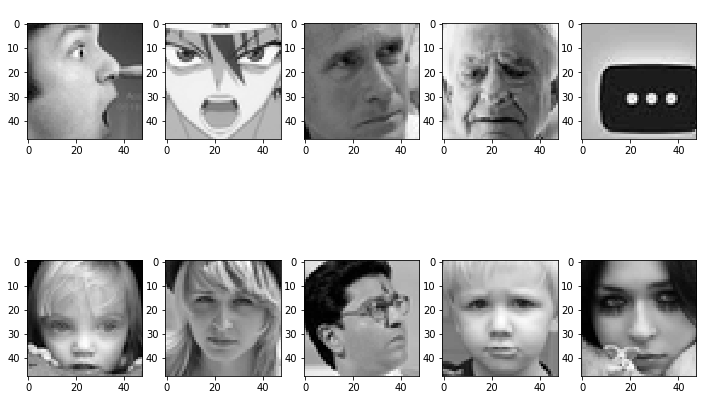

In [156]:
from operator import itemgetter
fig = plt.figure(figsize=(12,8))
sample = np.random.randint(0, len(flat_images),size=10)
for idx, val in enumerate(sample):
    ax = fig.add_subplot(2,5,idx+1)
    ax.imshow(flat_images[val].numpy().reshape(48,48), cmap='gray')
    ax.set_title(f"Label = {label_map[flat_label[val]]}", color='white')
    ax.set_xlabel(f'prediction = {label_map[flat_preds[val]]}',color='white')

## Real-time Facial Expression Classification

It's time we apply our emotion classifier in on streaming videos. There are a few things I'm not talking in detail here. Our real time classifier is implemented in combination with an object detection model - Mobilenet SSD (short for Single Shot Detection). Our emotion classifier needs facial images to be able to classify them into emotions. In a streaming video, the images are the frames per second of the video. The important thing here is the facial image in the video. We need a model that could capture facial images in the frames of the video in continuously feed them to our emotion classifier. This is where the Mobilenet SSD comes from. If you want to dig deeper, please refer to ([TO DO] more here)

In [15]:
import cv2
from imutils.video import VideoStream
from imutils.video import FPS
import time
label_map = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

# load our serialized face detector from disk
print("[INFO] loading face detector...")
protoPath = os.path.sep.join(["face_detection_model", "deploy.prototxt"])
modelPath = os.path.sep.join(["face_detection_model",
    "res10_300x300_ssd_iter_140000.caffemodel"])
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)


# Loading
model_path = './models/bn_dp_image_augmentation/bn_dp_augmentation.h5'
model = tf.keras.models.load_model(model_path)

# initialize the video stream, then allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)

# start the FPS throughput estimator
fps = FPS().start()

# loop over frames from the video file stream
while True:
    # grab the frame from the threaded video stream
    frame = vs.read()

    # resize the frame to have a width of 600 pixels (while
    # maintaining the aspect ratio), and then grab the image
    # dimensions
    frame = imutils.resize(frame, width=600)
    (h, w) = frame.shape[:2]

    # construct a blob from the image
    imageBlob = cv2.dnn.blobFromImage(
        cv2.resize(frame, (300, 300)), 1.0, (300, 300),
        (104.0, 177.0, 123.0), swapRB=False, crop=False)

    # apply OpenCV's deep learning-based face detector to localize
    # faces in the input image
    detector.setInput(imageBlob)
    detections = detector.forward()

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the face
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # extract the face region of interest
            face = frame[startY:endY, startX:endX] # The result is a numpy.darray 
            (fH, fW) = face.shape[:2]

            # ensure the face width and height are sufficiently large
            if fW < 20 or fH < 20:
                continue

            # Preprocess data for our model
            # It requires gray scale images of shape (48,48,1)
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            face = cv2.resize(face, (48,48))
            face = face.reshape(1,48,48,1)
            # perform classification to recognize the face
            preds = model.predict_proba(face, batch_size=None)
            j = np.argmax(preds[0])
            proba = preds[0][j]
            name = label_map[j]

            # draw the bounding box of the face along with the
            # associated probability
            text = "{}: {:.2f}%".format(name, proba * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(frame, (startX, startY), (endX, endY),
                (0, 0, 255), 2)
            cv2.putText(frame, text, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

    # update the FPS counter
    fps.update()

    # show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, exit the program
    if key == ord("q"):
        break

# stop the timer and display FPS information
fps.stop()
print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] loading face detector...
[INFO] starting video stream...
[INFO] elasped time: 61.10
[INFO] approx. FPS: 9.17
